In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

FILEMAP = {
    'BTC' : r'../resources/data/raw/BTC_USDT_1m.csv',
    'LINK' : r'../resources/data/raw/LINK_USDT_1m.csv',
    'TRX'  : r'../resources/data/raw/TRX_USDT_1m.csv',
    'ZRX'  : r'../resources/data/raw/ZRX_USDT_1m.csv',
}

COL_PRICE    = 'close'      # ценовата колона в CSV-то
TIMEZONE     = 'UTC'        # всички в UTC
RISK_FREE    = 0.00         # годишен r_f; 0.0 ако не ти трябва
WEIGHT_CAP   = 0.50         # ≤ 50 % в един актив
N_PORTFOLIOS = 25_000       # Монте Карло проби
SEED         = 42
TEST_FRAC = 0.20          # 20 % test
np.random.seed(SEED)

# --- 1-минутни барове → 525 600 на година ----------------------------
BAR_SEC           = 60
PERIODS_PER_YEAR  = int(365 * 86_400 / BAR_SEC) 
print(f'periods_per_year = {PERIODS_PER_YEAR:,}')

periods_per_year = 525,600


In [2]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 1) Зареждане на минутните цени                              ║
# ╚═════════════════════════════════════════════════════════════╝
def load_iso_csv(path: str | Path,
                 price_col: str = COL_PRICE,
                 tz: str = TIMEZONE) -> pd.Series:
    """
    Чете CSV с ISO `timestamp` и връща Series<price> (tz-aware).
    """
    df = pd.read_csv(path,
                     parse_dates=['timestamp'],
                     index_col='timestamp')
    df.index = df.index.tz_localize(tz)
    return df[price_col].astype(float)


# --- комбинираме всички активи ----------------------------------------
prices = pd.concat(
    {tkr: load_iso_csv(p) for tkr, p in FILEMAP.items()},
    axis=1, join='inner').sort_index()

# 2) намираме cut-off timestamp
cut_idx   = int(len(prices) * (1 - TEST_FRAC))
cut_date  = prices.index[cut_idx]          # tz-aware
print(f'🔪 Cut date (80/20 split) → {cut_date}')

# 3) правим две отделни рамки
train_prices = prices.loc[:cut_date]
test_prices  = prices.loc[cut_date + pd.Timedelta(minutes=1):]   # +1 мин. за да не дублираме

assert train_prices.index.max() < test_prices.index.min()
print(train_prices.shape, test_prices.shape)

🔪 Cut date (80/20 split) → 2024-03-27 12:29:00+00:00
(420492, 4) (105122, 4)


In [3]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 2) Минутни доходности, μ̅, Σ                                ║
# ╚═════════════════════════════════════════════════════════════╝
train_rets = train_prices.pct_change().dropna()

# проверка, че са 1-минутни
freq = train_rets.index.to_series().diff().dt.total_seconds().median()
assert freq == BAR_SEC, f'Открих {freq=} сек. – не е 1-мин серия!'

means_bar = train_rets.mean().values                  # μ_i  (за 1 бар)
cov_bar   = train_rets.cov().values                  # Σ    (за 1 бар)
tickers   = list(FILEMAP.keys())

# кратка статистика
stats = pd.DataFrame({'μ_bar': means_bar,
                      'σ_bar': train_rets.std(ddof=0).values},
                     index=tickers)
stats['Sharpe_bar'] = stats['μ_bar'] / stats['σ_bar']
display(stats)


,μ_bar,σ_bar,Sharpe_bar
BTC,0.000003,0.000642,0.003908
LINK,0.000004,0.001201,0.002955
TRX,0.000001,0.000454,0.002504
ZRX,0.000005,0.001686,0.003175


In [4]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 3) Монте-Карло портфейли (с ограничение на теглото)         ║
# ╚═════════════════════════════════════════════════════════════╝
n_assets = len(tickers)
results  = np.zeros((3, N_PORTFOLIOS))          # σ, μ, Sharpe
weights  = np.zeros((N_PORTFOLIOS, n_assets))

i = 0
while i < N_PORTFOLIOS:
    w = np.random.random(n_assets)
    w /= w.sum()
    if (w > WEIGHT_CAP).any():          # концентрационен лимит
        continue

    mu_bar  = np.dot(w, means_bar)
    sig_bar = np.sqrt(w @ cov_bar @ w)

    mu_ann  = mu_bar  * PERIODS_PER_YEAR
    sig_ann = sig_bar * np.sqrt(PERIODS_PER_YEAR)

    weights[i]   = w
    results[0,i] = sig_ann
    results[1,i] = mu_ann
    results[2,i] = (mu_ann - RISK_FREE) / sig_ann

    i += 1

idx_max_sharpe = results[2].argmax()
idx_min_vol    = results[0].argmin()


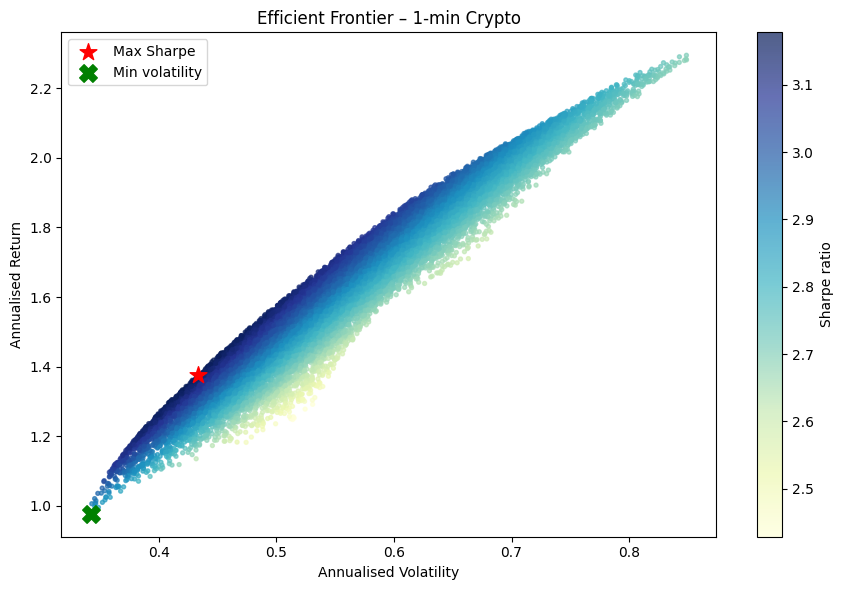

In [5]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 4) Графика: Efficient Frontier                             ║
# ╚═════════════════════════════════════════════════════════════╝
fig, ax = plt.subplots(figsize=(9, 6))
sc = ax.scatter(results[0], results[1],
                c=results[2], cmap='YlGnBu', s=8, alpha=0.7)
fig.colorbar(sc, label='Sharpe ratio')

ax.scatter(*results[:2, idx_max_sharpe],
           marker='*', s=160, color='r', label='Max Sharpe')
ax.scatter(*results[:2, idx_min_vol],
           marker='X', s=160, color='g', label='Min volatility')

ax.set(title='Efficient Frontier – 1-min Crypto',
       xlabel='Annualised Volatility',
       ylabel='Annualised Return')
ax.legend(); plt.tight_layout()


In [6]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 5) Показване на разпределенията                             ║
# ╚═════════════════════════════════════════════════════════════╝
alloc_max = pd.Series(weights[idx_max_sharpe], index=tickers).round(2)
alloc_min = pd.Series(weights[idx_min_vol   ], index=tickers).round(2)

print('\n' + '─'*70)
print('ПОРТФЕЙЛ С МАКС. SHARPE')
print(f"  Год. доходност : {results[1, idx_max_sharpe]:.2%}")
print(f"  Год. волатилност : {results[0, idx_max_sharpe]:.2%}\n")
display(alloc_max.to_frame('Weight').T)

print('\n' + '─'*70)
print('ПОРТФЕЙЛ С МИН. ВОЛАТИЛНОСТ')
print(f"  Год. доходност : {results[1, idx_min_vol]:.2%}")
print(f"  Год. волатилност : {results[0, idx_min_vol]:.2%}\n")
display(alloc_min.to_frame('Weight').T)



──────────────────────────────────────────────────────────────────────
ПОРТФЕЙЛ С МАКС. SHARPE
  Год. доходност : 137.64%
  Год. волатилност : 43.31%



,BTC,LINK,TRX,ZRX
Weight,0.49,0.03,0.3,0.17



──────────────────────────────────────────────────────────────────────
ПОРТФЕЙЛ С МИН. ВОЛАТИЛНОСТ
  Год. доходност : 97.66%
  Год. волатилност : 34.23%



,BTC,LINK,TRX,ZRX
Weight,0.48,0.02,0.49,0.0


In [7]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 6) Генетичен алгоритъм – оптимизация на Sharpe              ║
# ╚═════════════════════════════════════════════════════════════╝
import random

# --------------------------------------------------------------
# Хиперпараметри на GA
# --------------------------------------------------------------
POP_SIZE       = 1000          # колко индивида във всяко поколение
NB_GENERATIONS = 50             # колко поколения
ELITE_FRAC     = 0.10           # най-добрият % индивиди, които копираме директно
MUTATE_FRAC    = 0.15           # шанс дадено дете да бъде мутант
MUTATE_SCALE   = 0.10           # колко силно „рита“ мутантът теглото
PLOT_X = 5
PLOT_Y = 5


np.random.seed(123)

# --------------------------------------------------------------
# Фитнес функция – годишен Sharpe
# --------------------------------------------------------------
def fitness(w: np.ndarray) -> float:
    """
    w трябва вече да е нормализиран: Σ w_i = 1
    """
    mu_bar  = w @ means_bar
    sig_bar = np.sqrt(w @ cov_bar @ w)
    
    mu_ann  = mu_bar  * PERIODS_PER_YEAR
    sig_ann = sig_bar * np.sqrt(PERIODS_PER_YEAR)
    return (mu_ann - RISK_FREE) / sig_ann


# --------------------------------------------------------------
# GA инструменти: кросоувър, мутация, създаване на поколение
# --------------------------------------------------------------
def crossover(p1: np.ndarray, p2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Симпъл α-crossover (α ~ U[0,1])
    """
    α = np.random.rand()
    c1 = α * p1 + (1 - α) * p2
    c2 = (1 - α) * p1 + α * p2
    return c1, c2

def mutate(child: np.ndarray) -> np.ndarray:
    """
    Избутва случайно тегло с N(0, MUTATE_SCALE).
    После нормализира и реже до WEIGHT_CAP.
    """
    idx = np.random.randint(len(child))
    child[idx] += np.random.normal(0, MUTATE_SCALE)
    child = np.clip(child, 0, WEIGHT_CAP)      # защитно изрязване
    child /= child.sum()
    return child

def next_generation(pop: list[np.ndarray]) -> list[np.ndarray]:
    """
    Създава следващото поколение:
      1. сортира по fitness (низходящ)
      2. взема ELITE_FRAC като “елит”
      3. прави деца чрез кросоувър
      4. мутира част от децата
      5. нормализира теглата
    """
    pop = sorted(pop, key=fitness, reverse=True)
    elite_n = int(len(pop) * ELITE_FRAC)
    new_pop = pop[:elite_n]                       # запазваме елита
    
    # ––– рандомизираме елита, за да правим случайни двойки
    random.shuffle(new_pop)
    parents = new_pop.copy()
    
    # ––– кросоувър
    children = []
    for p1, p2 in zip(parents[::2], parents[1::2]):
        c1, c2 = crossover(p1, p2)
        children.extend([c1, c2])
    
    # ––– мутации
    for k in range(len(children)):
        if np.random.rand() < MUTATE_FRAC:
            children[k] = mutate(children[k])
        # задължителна нормализация + cap
        children[k] = np.clip(children[k], 0, WEIGHT_CAP)
        children[k] /= children[k].sum()
    
    new_pop.extend(children)
    
    # ако популацията е недостатъчна (нечетен брой родители)
    while len(new_pop) < POP_SIZE:
        w = np.random.random(len(tickers))
        w /= w.sum()
        if (w > WEIGHT_CAP).any():
            continue
        new_pop.append(w)
    return new_pop[:POP_SIZE]


# hyperparameters optimizer
import numpy as np, random, math, optuna, time
from copy import deepcopy
def run_ga_once(pop_size, nb_generations, elite_frac,
                mutate_frac, mutate_scale,
                weight_cap, seed=None):
    """
    Стартира ЕДНО изпълнение на GA с подадените хиперпараметри.
    Връща Sharpe на най-добрия индивид.
    """

    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # -------------- локални override-и на глобалните константи --------------
    global POP_SIZE, NB_GENERATIONS, ELITE_FRAC
    global MUTATE_FRAC, MUTATE_SCALE, WEIGHT_CAP

    POP_SIZE       = pop_size
    NB_GENERATIONS = nb_generations
    ELITE_FRAC     = elite_frac
    MUTATE_FRAC    = mutate_frac
    MUTATE_SCALE   = mutate_scale
    WEIGHT_CAP     = weight_cap          # нов параметър!

    # -------------- инициализираме първото поколение ------------------------
    population = []
    while len(population) < POP_SIZE:
        w = np.random.random(len(tickers))
        w /= w.sum()
        if (w > WEIGHT_CAP).any():
            continue
        population.append(w)

    # -------------- еволюираме ----------------------------------------------
    best_fit = -math.inf
    for g in range(NB_GENERATIONS):
        population = next_generation(population)
        # оценяваме елита
        top = max(population, key=fitness)
        best_fit = max(best_fit, fitness(top))

    return best_fit   # ↑ Sharpe на най-силния индивид

def objective(trial: optuna.trial.Trial) -> float:
    """
    Optuna ще пробва различни GA-хиперпараметри и ще
    връща >>средния<< Sharpe от K рестарта на GA.
    """
    # 1) дефинираме търсено пространство
    pop_size       = trial.suggest_int   ('pop_size',        200, 1500, step=100)
    nb_generations = trial.suggest_int   ('nb_generations',   20, 200,  step=10)
    elite_frac     = trial.suggest_float ('elite_frac',      0.05, 0.35)
    mutate_frac    = trial.suggest_float ('mutate_frac',     0.05, 0.40)
    mutate_scale   = trial.suggest_float ('mutate_scale',    0.01, 0.50, log=True)
    weight_cap     = trial.suggest_float ('weight_cap',      0.30, 0.70)

    # 2) за стабилност ‒ стартираме GA K пъти с разл. seed
    K, scores = 3, []
    for k in range(K):
        seed = 2024 + k
        score = run_ga_once(pop_size, nb_generations,
                            elite_frac, mutate_frac, mutate_scale,
                            weight_cap, seed=seed)
        scores.append(score)

    # 3) Optuna максимизира -> връщаме средната стойност
    return float(np.mean(scores))

study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(),
                            pruner =optuna.pruners.MedianPruner(
                                        n_startup_trials=10, n_warmup_steps=5))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
study.optimize(objective,
               n_trials = 40,          # или по време: timeout=3600
               show_progress_bar=True)

print("🏆 Най-добрите GA-хиперпараметри:")
for k, v in study.best_trial.params.items():
    print(f"  {k:15s} : {v}")
print("Среден Sharpe  :", study.best_value)




/home/npenchev/fun/summer-school-2025-crypto-forecasting/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-28 20:44:03,980] A new study created in memory with name: no-name-2265d33f-e422-4748-a866-c1a2cb908744
Best trial: 0. Best value: 3.19368:   2%|█                                           | 1/40 [00:02<01:31,  2.34s/it]

[I 2025-06-28 20:44:06,321] Trial 0 finished with value: 3.1936777911042475 and parameters: {'pop_size': 1500, 'nb_generations': 20, 'elite_frac': 0.10357601249557188, 'mutate_frac': 0.06996584204709577, 'mutate_scale': 0.018037007093387264, 'weight_cap': 0.6919298254354129}. Best is trial 0 with value: 3.1936777911042475.


Best trial: 0. Best value: 3.19368:   5%|██▏                                         | 2/40 [00:09<03:20,  5.27s/it]

[I 2025-06-28 20:44:13,640] Trial 1 finished with value: 3.1344629729240054 and parameters: {'pop_size': 700, 'nb_generations': 80, 'elite_frac': 0.25540699709177767, 'mutate_frac': 0.17815523619457302, 'mutate_scale': 0.015863153695780455, 'weight_cap': 0.35333681279651424}. Best is trial 0 with value: 3.1936777911042475.


Best trial: 0. Best value: 3.19368:   8%|███▎                                        | 3/40 [00:24<05:59,  9.73s/it]

[I 2025-06-28 20:44:28,666] Trial 2 finished with value: 3.1929838917413504 and parameters: {'pop_size': 900, 'nb_generations': 190, 'elite_frac': 0.341171187360725, 'mutate_frac': 0.14831732831097516, 'mutate_scale': 0.017506181749552062, 'weight_cap': 0.5618515213125357}. Best is trial 0 with value: 3.1936777911042475.


Best trial: 0. Best value: 3.19368:  10%|████▍                                       | 4/40 [00:31<05:04,  8.45s/it]

[I 2025-06-28 20:44:35,169] Trial 3 finished with value: 3.1912200672358146 and parameters: {'pop_size': 500, 'nb_generations': 150, 'elite_frac': 0.08359694116435132, 'mutate_frac': 0.2045463106948266, 'mutate_scale': 0.07808845171395543, 'weight_cap': 0.536135685363018}. Best is trial 0 with value: 3.1936777911042475.


Best trial: 0. Best value: 3.19368:  12%|█████▌                                      | 5/40 [00:39<04:56,  8.47s/it]

[I 2025-06-28 20:44:43,659] Trial 4 finished with value: 3.1706733908753897 and parameters: {'pop_size': 1500, 'nb_generations': 60, 'elite_frac': 0.23055883383881215, 'mutate_frac': 0.2600107170836722, 'mutate_scale': 0.21370863467776957, 'weight_cap': 0.440351620801546}. Best is trial 0 with value: 3.1936777911042475.


Best trial: 0. Best value: 3.19368:  15%|██████▌                                     | 6/40 [00:50<05:16,  9.31s/it]

[I 2025-06-28 20:44:54,586] Trial 5 finished with value: 3.139715691643369 and parameters: {'pop_size': 800, 'nb_generations': 110, 'elite_frac': 0.2917203476278689, 'mutate_frac': 0.26830721688905246, 'mutate_scale': 0.2851603189242053, 'weight_cap': 0.34885136295887126}. Best is trial 0 with value: 3.1936777911042475.


Best trial: 0. Best value: 3.19368:  18%|███████▋                                    | 7/40 [00:54<04:13,  7.69s/it]

[I 2025-06-28 20:44:58,972] Trial 6 finished with value: 3.1814687791230405 and parameters: {'pop_size': 400, 'nb_generations': 120, 'elite_frac': 0.17639603322238262, 'mutate_frac': 0.391395146394011, 'mutate_scale': 0.15710434670025117, 'weight_cap': 0.47726363969155206}. Best is trial 0 with value: 3.1936777911042475.


Best trial: 7. Best value: 3.19369:  20%|████████▊                                   | 8/40 [01:06<04:42,  8.84s/it]

[I 2025-06-28 20:45:10,256] Trial 7 finished with value: 3.193686360181855 and parameters: {'pop_size': 1000, 'nb_generations': 130, 'elite_frac': 0.213027982040221, 'mutate_frac': 0.17361287279527557, 'mutate_scale': 0.04962944420882369, 'weight_cap': 0.6747723011775779}. Best is trial 7 with value: 3.193686360181855.


Best trial: 7. Best value: 3.19369:  22%|█████████▉                                  | 9/40 [01:07<03:21,  6.51s/it]

[I 2025-06-28 20:45:11,646] Trial 8 finished with value: 3.192546185276045 and parameters: {'pop_size': 400, 'nb_generations': 40, 'elite_frac': 0.23534001678062172, 'mutate_frac': 0.12439085191528072, 'mutate_scale': 0.028363117163905195, 'weight_cap': 0.5570602614555489}. Best is trial 7 with value: 3.193686360181855.


Best trial: 7. Best value: 3.19369:  25%|██████████▊                                | 10/40 [01:09<02:28,  4.96s/it]

[I 2025-06-28 20:45:13,129] Trial 9 finished with value: 3.1884064204217526 and parameters: {'pop_size': 200, 'nb_generations': 80, 'elite_frac': 0.2689539261818165, 'mutate_frac': 0.09695634485639629, 'mutate_scale': 0.012226242566555523, 'weight_cap': 0.51848265987402}. Best is trial 7 with value: 3.193686360181855.


Best trial: 10. Best value: 3.19369:  28%|███████████▌                              | 11/40 [01:27<04:24,  9.12s/it]

[I 2025-06-28 20:45:31,685] Trial 10 finished with value: 3.193686386767709 and parameters: {'pop_size': 1100, 'nb_generations': 200, 'elite_frac': 0.15716348059355997, 'mutate_frac': 0.3278031203515892, 'mutate_scale': 0.050678564578068394, 'weight_cap': 0.682508394531169}. Best is trial 10 with value: 3.193686386767709.


Best trial: 10. Best value: 3.19369:  30%|████████████▌                             | 12/40 [01:45<05:32, 11.86s/it]

[I 2025-06-28 20:45:49,811] Trial 11 finished with value: 3.1936863865966814 and parameters: {'pop_size': 1100, 'nb_generations': 190, 'elite_frac': 0.16023659500523924, 'mutate_frac': 0.34688295997705404, 'mutate_scale': 0.048158561845198795, 'weight_cap': 0.697688963675132}. Best is trial 10 with value: 3.193686386767709.


Best trial: 10. Best value: 3.19369:  32%|█████████████▋                            | 13/40 [02:07<06:39, 14.78s/it]

[I 2025-06-28 20:46:11,311] Trial 12 finished with value: 3.193686385230357 and parameters: {'pop_size': 1200, 'nb_generations': 200, 'elite_frac': 0.14901553341607987, 'mutate_frac': 0.35224764908789963, 'mutate_scale': 0.07343797647594473, 'weight_cap': 0.6174805415668454}. Best is trial 10 with value: 3.193686386767709.


Best trial: 10. Best value: 3.19369:  35%|██████████████▋                           | 14/40 [02:25<06:48, 15.73s/it]

[I 2025-06-28 20:46:29,223] Trial 13 finished with value: 3.193686384169587 and parameters: {'pop_size': 1200, 'nb_generations': 170, 'elite_frac': 0.13442579910062968, 'mutate_frac': 0.3262316978191733, 'mutate_scale': 0.037617225872907535, 'weight_cap': 0.6298897550621033}. Best is trial 10 with value: 3.193686386767709.


Best trial: 10. Best value: 3.19369:  38%|███████████████▊                          | 15/40 [02:42<06:43, 16.12s/it]

[I 2025-06-28 20:46:46,258] Trial 14 finished with value: 3.193686364991725 and parameters: {'pop_size': 1200, 'nb_generations': 170, 'elite_frac': 0.05257159531674378, 'mutate_frac': 0.3071336822850384, 'mutate_scale': 0.11521518078215685, 'weight_cap': 0.6252092380859252}. Best is trial 10 with value: 3.193686386767709.


Best trial: 10. Best value: 3.19369:  40%|████████████████▊                         | 16/40 [02:58<06:26, 16.09s/it]

[I 2025-06-28 20:47:02,270] Trial 15 finished with value: 3.193686385337703 and parameters: {'pop_size': 1100, 'nb_generations': 170, 'elite_frac': 0.17802548643994381, 'mutate_frac': 0.37377564882112574, 'mutate_scale': 0.4182378573644198, 'weight_cap': 0.6907322070179907}. Best is trial 10 with value: 3.193686386767709.


Best trial: 10. Best value: 3.19369:  42%|█████████████████▊                        | 17/40 [03:22<07:05, 18.50s/it]

[I 2025-06-28 20:47:26,394] Trial 16 finished with value: 3.193686386246506 and parameters: {'pop_size': 1400, 'nb_generations': 200, 'elite_frac': 0.13529976566354682, 'mutate_frac': 0.28742456834596253, 'mutate_scale': 0.04561140289811433, 'weight_cap': 0.5992818304138554}. Best is trial 10 with value: 3.193686386767709.


Best trial: 10. Best value: 3.19369:  45%|██████████████████▉                       | 18/40 [03:31<05:46, 15.76s/it]

[I 2025-06-28 20:47:35,774] Trial 17 finished with value: 3.1741318982352893 and parameters: {'pop_size': 700, 'nb_generations': 140, 'elite_frac': 0.18699641029381198, 'mutate_frac': 0.34022735757056555, 'mutate_scale': 0.10275274873996222, 'weight_cap': 0.4507647017935634}. Best is trial 10 with value: 3.193686386767709.


Best trial: 10. Best value: 3.19369:  48%|███████████████████▉                      | 19/40 [03:57<06:33, 18.74s/it]

[I 2025-06-28 20:48:01,446] Trial 18 finished with value: 3.153451903010735 and parameters: {'pop_size': 1300, 'nb_generations': 180, 'elite_frac': 0.09853931487975834, 'mutate_frac': 0.23208488669946964, 'mutate_scale': 0.027578756331904257, 'weight_cap': 0.39779590395330905}. Best is trial 10 with value: 3.193686386767709.


Best trial: 10. Best value: 3.19369:  50%|█████████████████████                     | 20/40 [04:06<05:16, 15.83s/it]

[I 2025-06-28 20:48:10,504] Trial 19 finished with value: 3.1936863851047903 and parameters: {'pop_size': 1000, 'nb_generations': 100, 'elite_frac': 0.1672757072633039, 'mutate_frac': 0.39554732056734804, 'mutate_scale': 0.053443916907454043, 'weight_cap': 0.6486877771556268}. Best is trial 10 with value: 3.193686386767709.


Best trial: 10. Best value: 3.19369:  52%|██████████████████████                    | 21/40 [04:20<04:50, 15.28s/it]

[I 2025-06-28 20:48:24,505] Trial 20 finished with value: 3.1935492017291076 and parameters: {'pop_size': 1000, 'nb_generations': 150, 'elite_frac': 0.20379146508923698, 'mutate_frac': 0.3068543014189305, 'mutate_scale': 0.027434170901472158, 'weight_cap': 0.5794464548276901}. Best is trial 10 with value: 3.193686386767709.


Best trial: 21. Best value: 3.19369:  55%|███████████████████████                   | 22/40 [04:44<05:22, 17.89s/it]

[I 2025-06-28 20:48:48,480] Trial 21 finished with value: 3.1936863868046266 and parameters: {'pop_size': 1400, 'nb_generations': 200, 'elite_frac': 0.13079692658084563, 'mutate_frac': 0.2824565027384888, 'mutate_scale': 0.049820098392307596, 'weight_cap': 0.6010355307099228}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 21. Best value: 3.19369:  57%|████████████████████████▏                 | 23/40 [05:08<05:36, 19.81s/it]

[I 2025-06-28 20:49:12,762] Trial 22 finished with value: 3.193686385552627 and parameters: {'pop_size': 1300, 'nb_generations': 200, 'elite_frac': 0.11491776176480795, 'mutate_frac': 0.24148996155835126, 'mutate_scale': 0.06120097688216014, 'weight_cap': 0.6691775673735584}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 21. Best value: 3.19369:  60%|█████████████████████████▏                | 24/40 [05:29<05:20, 20.01s/it]

[I 2025-06-28 20:49:33,238] Trial 23 finished with value: 3.193686386527784 and parameters: {'pop_size': 1300, 'nb_generations': 180, 'elite_frac': 0.15093145335831226, 'mutate_frac': 0.3589202050617373, 'mutate_scale': 0.03613562093957663, 'weight_cap': 0.6573875329149023}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 21. Best value: 3.19369:  62%|██████████████████████████▎               | 25/40 [05:48<04:57, 19.86s/it]

[I 2025-06-28 20:49:52,745] Trial 24 finished with value: 3.1936863772580453 and parameters: {'pop_size': 1400, 'nb_generations': 160, 'elite_frac': 0.05870412496181879, 'mutate_frac': 0.3236424275113774, 'mutate_scale': 0.09784329069243704, 'weight_cap': 0.6995355978439469}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 21. Best value: 3.19369:  65%|███████████████████████████▎              | 26/40 [06:07<04:33, 19.51s/it]

[I 2025-06-28 20:50:11,441] Trial 25 finished with value: 3.193642030985661 and parameters: {'pop_size': 1100, 'nb_generations': 190, 'elite_frac': 0.1295013450085481, 'mutate_frac': 0.2887691163917428, 'mutate_scale': 0.03591479646513058, 'weight_cap': 0.5864243746825968}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 21. Best value: 3.19369:  68%|████████████████████████████▎             | 27/40 [06:21<03:52, 17.89s/it]

[I 2025-06-28 20:50:25,538] Trial 26 finished with value: 3.193686229981564 and parameters: {'pop_size': 900, 'nb_generations': 180, 'elite_frac': 0.07994065801789116, 'mutate_frac': 0.2708126381630382, 'mutate_scale': 0.14078058341080665, 'weight_cap': 0.649466271979681}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 21. Best value: 3.19369:  70%|█████████████████████████████▍            | 28/40 [06:41<03:40, 18.41s/it]

[I 2025-06-28 20:50:45,180] Trial 27 finished with value: 3.1936863835502276 and parameters: {'pop_size': 1100, 'nb_generations': 200, 'elite_frac': 0.15058118739143178, 'mutate_frac': 0.35856490904449567, 'mutate_scale': 0.07587079349936054, 'weight_cap': 0.6121148323425328}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 21. Best value: 3.19369:  72%|██████████████████████████████▍           | 29/40 [07:01<03:27, 18.91s/it]

[I 2025-06-28 20:51:05,242] Trial 28 finished with value: 3.1936863849589727 and parameters: {'pop_size': 1400, 'nb_generations': 160, 'elite_frac': 0.19740056092299232, 'mutate_frac': 0.2118095440142888, 'mutate_scale': 0.042608394872187545, 'weight_cap': 0.6373103183801303}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 21. Best value: 3.19369:  75%|███████████████████████████████▌          | 30/40 [07:26<03:29, 20.93s/it]

[I 2025-06-28 20:51:30,901] Trial 29 finished with value: 3.1936863858491993 and parameters: {'pop_size': 1500, 'nb_generations': 190, 'elite_frac': 0.11292912035158127, 'mutate_frac': 0.05635871715603549, 'mutate_scale': 0.0203160435041405, 'weight_cap': 0.6995472647554971}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 21. Best value: 3.19369:  78%|████████████████████████████████▌         | 31/40 [08:08<04:05, 27.27s/it]

[I 2025-06-28 20:52:12,949] Trial 30 finished with value: 3.088132363662062 and parameters: {'pop_size': 800, 'nb_generations': 150, 'elite_frac': 0.15784423179530513, 'mutate_frac': 0.3174026013002477, 'mutate_scale': 0.010047551781119404, 'weight_cap': 0.3096050175908437}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 21. Best value: 3.19369:  80%|█████████████████████████████████▌        | 32/40 [08:29<03:21, 25.24s/it]

[I 2025-06-28 20:52:33,447] Trial 31 finished with value: 3.1936863867746954 and parameters: {'pop_size': 1300, 'nb_generations': 180, 'elite_frac': 0.12495308974382704, 'mutate_frac': 0.3655828218474212, 'mutate_scale': 0.03452929559391095, 'weight_cap': 0.6668363271472103}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 21. Best value: 3.19369:  82%|██████████████████████████████████▋       | 33/40 [08:48<02:43, 23.31s/it]

[I 2025-06-28 20:52:52,273] Trial 32 finished with value: 3.1936863852026214 and parameters: {'pop_size': 1200, 'nb_generations': 180, 'elite_frac': 0.09575125488017125, 'mutate_frac': 0.3760280688614237, 'mutate_scale': 0.022853288246775676, 'weight_cap': 0.6677702012069009}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 21. Best value: 3.19369:  85%|███████████████████████████████████▋      | 34/40 [09:10<02:17, 22.92s/it]

[I 2025-06-28 20:53:14,272] Trial 33 finished with value: 3.1936863866747296 and parameters: {'pop_size': 1300, 'nb_generations': 190, 'elite_frac': 0.12233037105404716, 'mutate_frac': 0.33954950732217104, 'mutate_scale': 0.05990889253768236, 'weight_cap': 0.67869563290952}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 21. Best value: 3.19369:  88%|████████████████████████████████████▊     | 35/40 [09:34<01:57, 23.41s/it]

[I 2025-06-28 20:53:38,832] Trial 34 finished with value: 3.1928180460021447 and parameters: {'pop_size': 1400, 'nb_generations': 200, 'elite_frac': 0.11842126362572168, 'mutate_frac': 0.2902842192206737, 'mutate_scale': 0.06167644555825175, 'weight_cap': 0.5592326607743414}. Best is trial 21 with value: 3.1936863868046266.


Best trial: 35. Best value: 3.19369:  90%|█████████████████████████████████████▊    | 36/40 [09:55<01:30, 22.67s/it]

[I 2025-06-28 20:53:59,778] Trial 35 finished with value: 3.1936863868084515 and parameters: {'pop_size': 1500, 'nb_generations': 160, 'elite_frac': 0.07981016774916722, 'mutate_frac': 0.3366198847537157, 'mutate_scale': 0.01510773934547054, 'weight_cap': 0.6692132771928342}. Best is trial 35 with value: 3.1936863868084515.


Best trial: 35. Best value: 3.19369:  92%|██████████████████████████████████████▊   | 37/40 [10:16<01:06, 22.17s/it]

[I 2025-06-28 20:54:20,789] Trial 36 finished with value: 3.193686385444017 and parameters: {'pop_size': 1500, 'nb_generations': 160, 'elite_frac': 0.07423691293377496, 'mutate_frac': 0.3732391298430522, 'mutate_scale': 0.017466695497352438, 'weight_cap': 0.5996030593300499}. Best is trial 35 with value: 3.1936863868084515.


Best trial: 35. Best value: 3.19369:  95%|███████████████████████████████████████▉  | 38/40 [10:36<00:42, 21.46s/it]

[I 2025-06-28 20:54:40,581] Trial 37 finished with value: 3.1911539570408305 and parameters: {'pop_size': 1500, 'nb_generations': 140, 'elite_frac': 0.09608112221025336, 'mutate_frac': 0.25534153924702774, 'mutate_scale': 0.013659252940858868, 'weight_cap': 0.5378594513536262}. Best is trial 35 with value: 3.1936863868084515.


Best trial: 35. Best value: 3.19369:  98%|████████████████████████████████████████▉ | 39/40 [10:39<00:15, 15.80s/it]

[I 2025-06-28 20:54:43,188] Trial 38 finished with value: 3.19368480322465 and parameters: {'pop_size': 1400, 'nb_generations': 20, 'elite_frac': 0.08364258902084915, 'mutate_frac': 0.29594876112021906, 'mutate_scale': 0.02320603165108595, 'weight_cap': 0.6413858897347429}. Best is trial 35 with value: 3.1936863868084515.


Best trial: 35. Best value: 3.19369: 100%|██████████████████████████████████████████| 40/40 [10:51<00:00, 16.28s/it]

[I 2025-06-28 20:54:55,135] Trial 39 finished with value: 3.1936863864923004 and parameters: {'pop_size': 1300, 'nb_generations': 100, 'elite_frac': 0.3328081774284911, 'mutate_frac': 0.32894076279243156, 'mutate_scale': 0.014607715531434326, 'weight_cap': 0.6607241468185144}. Best is trial 35 with value: 3.1936863868084515.
🏆 Най-добрите GA-хиперпараметри:
  pop_size        : 1500
  nb_generations  : 160
  elite_frac      : 0.07981016774916722
  mutate_frac     : 0.3366198847537157
  mutate_scale    : 0.01510773934547054
  weight_cap      : 0.6692132771928342
Среден Sharpe  : 3.1936863868084515


In [8]:
    # POP_SIZE       = pop_size
    # NB_GENERATIONS = nb_generations
    # ELITE_FRAC     = elite_frac
    # MUTATE_FRAC    = mutate_frac
    # MUTATE_SCALE   = mutate_scale
    # WEIGHT_CAP     = weight_cap 
print("OPTIMIZED HYPERPARAMETERS")
print(f"POP_SIZE: {POP_SIZE}")
print(f"NB_GENERATIONS: {NB_GENERATIONS}")
print(f"ELITE_FRAC: {ELITE_FRAC}")
print(f"MUTATE_FRAC: {MUTATE_FRAC}")
print(f"MUTATE_SCALE: {MUTATE_SCALE}")
print(f"WEIGHT_CAP: {WEIGHT_CAP}")

OPTIMIZED HYPERPARAMETERS
POP_SIZE: 1300
NB_GENERATIONS: 100
ELITE_FRAC: 0.3328081774284911
MUTATE_FRAC: 0.32894076279243156
MUTATE_SCALE: 0.014607715531434326
WEIGHT_CAP: 0.6607241468185144


Ще се визуализират поколения: [0, 4, 8, 12, 16, 20, 24, 28, 33, 37, 41, 45, 49, 53, 57, 61, 66, 70, 74, 78, 82, 86, 90, 94, 99]


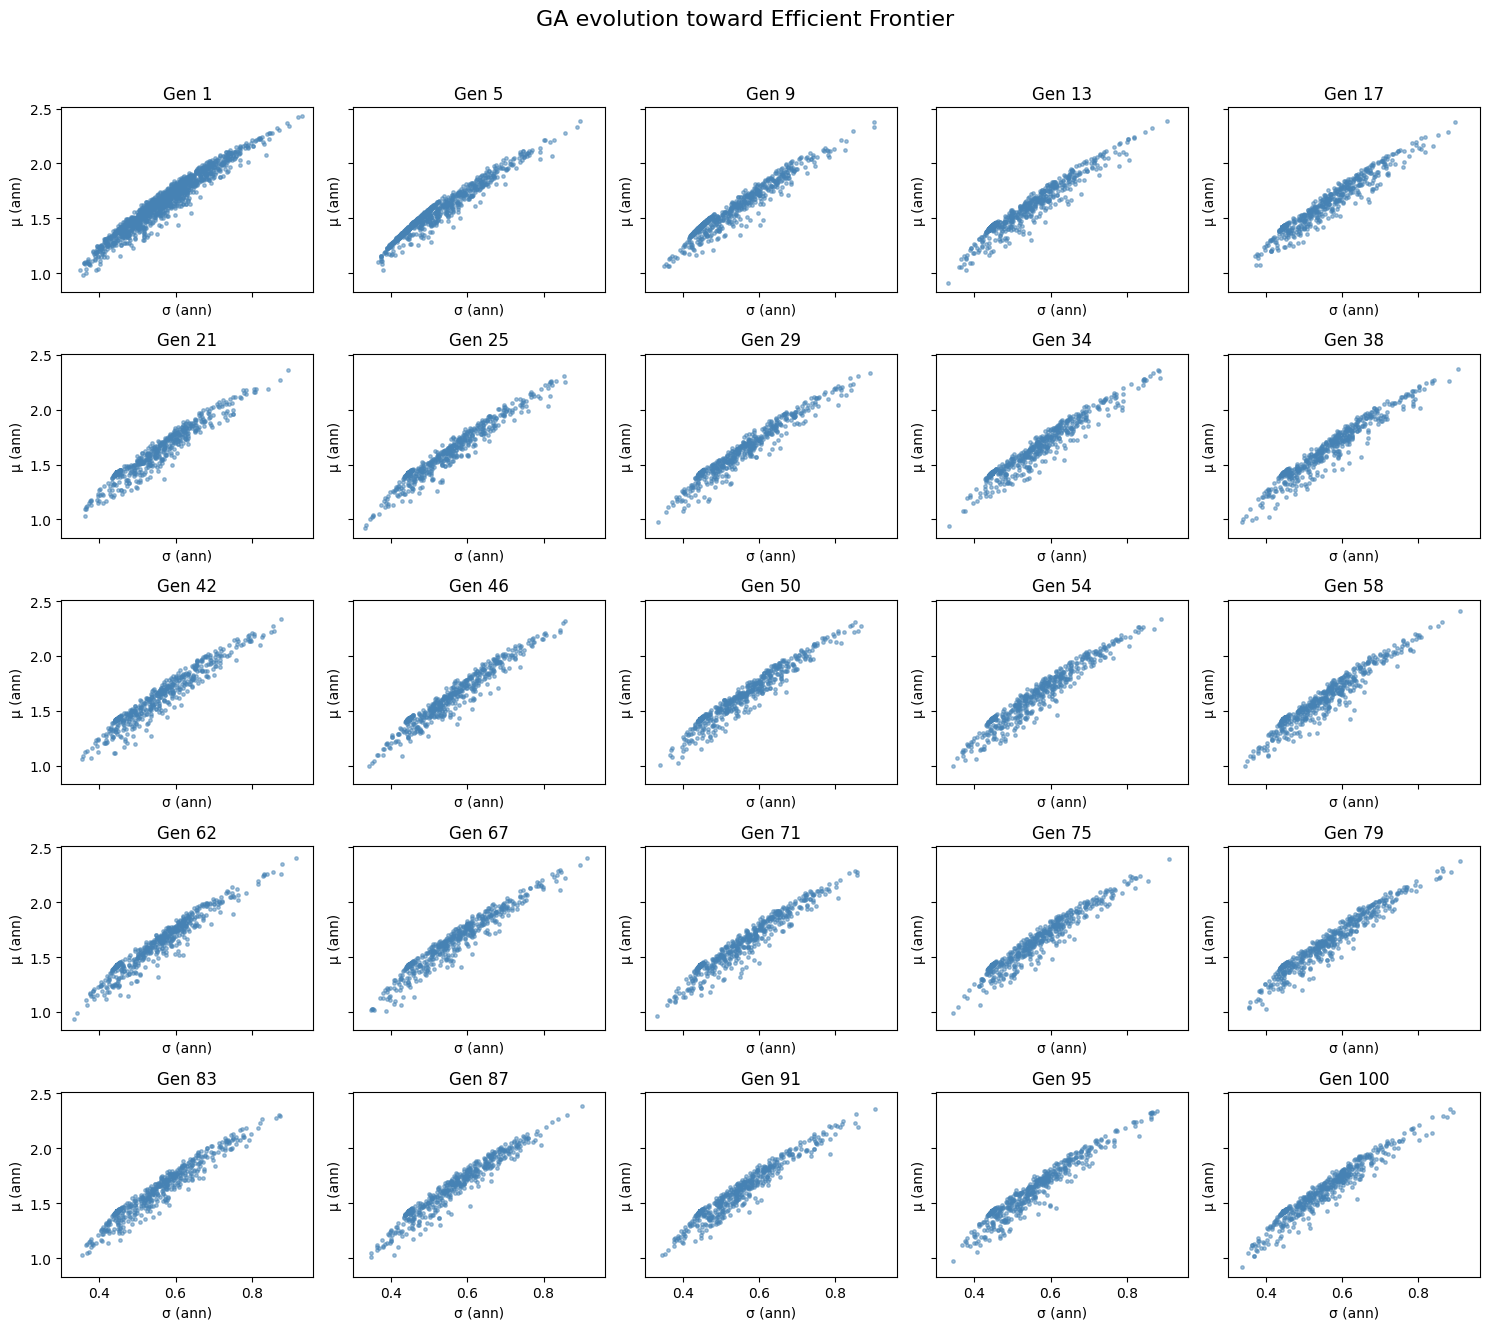

In [11]:
# --------------------------------------------------------------
# 6.1) Инициализация на първото поколение
# --------------------------------------------------------------
population = []
while len(population) < POP_SIZE:
    w = np.random.random(len(tickers))
    w /= w.sum()
    if (w > WEIGHT_CAP).any():
        continue
    population.append(w)

# --------------------------------------------------------------
# 6.2) Еволюция и визуализация
# --------------------------------------------------------------
# fig, axs = plt.subplots(PLOT_X, PLOT_Y, figsize=(15, 13), sharex=True, sharey=True)
# axs = axs.flatten()

fig, axs = plt.subplots(PLOT_Y, PLOT_X, figsize=(15, 13),
                        sharex=True, sharey=True)
axs = axs.flatten()
MAX_PLOTS = PLOT_X * PLOT_Y      # 25

# кои поколения ще рисуваме
if NB_GENERATIONS <= MAX_PLOTS:
    gens_to_plot = list(range(NB_GENERATIONS))
else:
    # равномерни индекси, винаги включва 0
    gens_to_plot = (np.linspace(0, NB_GENERATIONS - 1,
                                num=MAX_PLOTS, dtype=int)
                      .tolist())

print("Ще се визуализират поколения:", gens_to_plot)

for g in range(NB_GENERATIONS):
    # ── статистика за текущото поколение ───────────────────────
    res = np.zeros((2, POP_SIZE))            # σ, μ  (годишни)
    for i, w in enumerate(population):
        mu_bar  = w @ means_bar
        sig_bar = np.sqrt(w @ cov_bar @ w)
        res[1, i] = mu_bar  * PERIODS_PER_YEAR
        res[0, i] = sig_bar * np.sqrt(PERIODS_PER_YEAR)

    # ── чертаем само ако g e в списъка ──────────────────────────
    if g in gens_to_plot:
        plot_idx = gens_to_plot.index(g)     # 0 … 24
        ax = axs[plot_idx]
        ax.scatter(res[0], res[1], s=6, alpha=0.5, c='steelblue')
        ax.set_title(f'Gen {g+1}')
        ax.set_xlabel('σ (ann)')
        ax.set_ylabel('μ (ann)')

    # ── еволюираме към следващо поколение ───────────────────────
    population = next_generation(population)

plt.suptitle('GA evolution toward Efficient Frontier', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [12]:
TOP_N = 20        # how many best portfolios you want to list

def ann_stats(w: np.ndarray) -> tuple[float, float, float]:
    mu_bar  = w @ means_bar
    sig_bar = np.sqrt(w @ cov_bar @ w)
    mu_ann  = mu_bar  * PERIODS_PER_YEAR
    sig_ann = sig_bar * np.sqrt(PERIODS_PER_YEAR)
    sharpe  = (mu_ann - RISK_FREE) / sig_ann
    return mu_ann, sig_ann, sharpe

# 1) take the best TOP_N by Sharpe
best_pop = sorted(population, key=fitness, reverse=True)[:TOP_N]

# 2) build one combined table
records = []
for rank, w in enumerate(best_pop, 1):
    mu, sig, shp = ann_stats(w)
    rec = {
        'Rank'      : rank,
        'Annual μ'  : round(mu, 4),
        'Annual σ'  : round(sig, 4),
        'Sharpe'    : round(shp, 3)
    }
    # add the weights, rounded to 3 dp
    rec.update({tkr: round(w[i], 3) for i, tkr in enumerate(tickers)})
    records.append(rec)

top_df = (pd.DataFrame(records)
            .set_index('Rank')
            .sort_index())

display(top_df)


,Annual μ,Annual σ,Sharpe,BTC,LINK,TRX,ZRX
Rank,,,,,,,
1,1.4254,0.4463,3.194,0.594,0.04,0.209,0.157
2,1.4254,0.4463,3.194,0.594,0.04,0.209,0.157
3,1.4254,0.4463,3.194,0.594,0.04,0.209,0.157
4,1.4254,0.4463,3.194,0.594,0.04,0.209,0.157
5,1.4254,0.4463,3.194,0.594,0.04,0.209,0.157
6,1.4254,0.4463,3.194,0.594,0.04,0.209,0.157
7,1.4254,0.4463,3.194,0.594,0.04,0.209,0.157
8,1.4254,0.4463,3.194,0.594,0.04,0.209,0.157
9,1.4254,0.4463,3.194,0.594,0.04,0.209,0.157


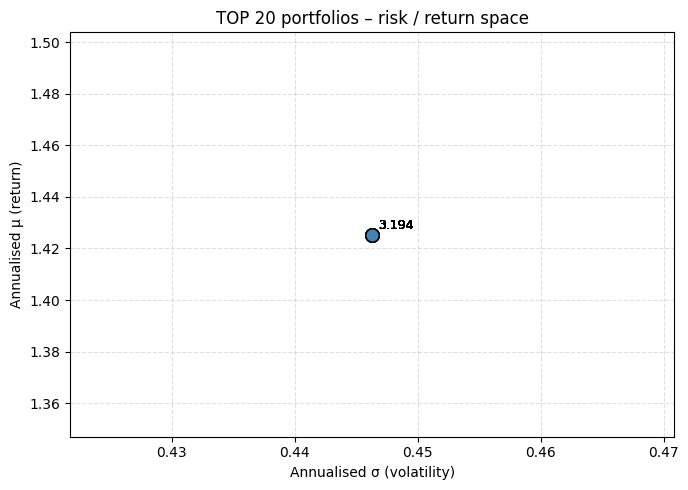

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(top_df['Annual σ'], top_df['Annual μ'],
            s=90, color='steelblue', edgecolors='k', alpha=0.8)

# (по желание) етикет към всяка точка – номерът в класацията
for rank, row in top_df.iterrows():
    plt.annotate(str(row['Sharpe']),
                 (row['Annual σ'], row['Annual μ']),
                 textcoords="offset points",
                 xytext=(4, 4), ha='left', fontsize=9)

plt.xlabel('Annualised σ (volatility)')
plt.ylabel('Annualised μ (return)')
plt.title(f'TOP {len(top_df)} portfolios – risk / return space')
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [14]:
best_w = top_df.iloc[0][tickers].to_dict()
best_w

# ПОРТФЕЙЛ С МАКС. SHARPE
#   Год. доходност : 98.79%
#   Год. волатилност : 60.37%

# BTC	ADA	ALGO	ANKR
# Weight	0.5	0.11	0.09	0.3

# ──────────────────────────────────────────────────────────────────────
# ПОРТФЕЙЛ С МИН. ВОЛАТИЛНОСТ
#   Год. доходност : 90.08%
#   Год. волатилност : 57.66%

# BTC	ADA	ALGO	ANKR
# Weight	0.5	0.31	0.12	0.07

{'BTC': 0.594, 'LINK': 0.04, 'TRX': 0.209, 'ZRX': 0.157}

In [15]:
# -*- coding: utf-8 -*-
"""
Backtrader static-weight portfolio back-test
"""
import matplotlib
matplotlib.use('Agg')  
import backtrader as bt
import pandas as pd
from pathlib import Path


# ---------- Параметри ------------------------------------------------------

WEIGHTS = best_w

DATA_DIR       = Path('../resources/data/raw')   # коригирай пътя, ако е нужно
STARTING_CASH  = 100_000
COMMISSION     = 0.001        # 0.1 %
REBALANCE_DAYS = 30         # напр. 30 за месечен ребаланс


# ---------- Стратегия ------------------------------------------------------

class StaticWeightStrategy(bt.Strategy):
    """
    Поддържа фиксирани тегла. Ребалансира:
      • веднъж на първата свещ;
      • през `rebalance_days`, ако е зададено.
    """
    params = (
        ('weights',         None),
        ('rebalance_days',  None),
    )

    def __init__(self):
        self.rebalanced_init = False     # ще ребалансираме при първата свещ
        self.last_rebalance  = None      # календарно следене (ако е нужно)

    # --------------------------------------------------
    def next(self):
        dt = self.datas[0].datetime.date(0)   # текуща дата

        # --- първоначален ребаланс ---------------------------------
        if not self.rebalanced_init:
            self.rebalance()
            self.rebalanced_init = True
            self.last_rebalance  = dt
            return                          # излизаме, за да не удвоим ребаланса

        # --- периодичен ребаланс -----------------------------------
        if self.p.rebalance_days:
            if (dt - self.last_rebalance).days >= self.p.rebalance_days:
                self.rebalance()
                self.last_rebalance = dt

    # --------------------------------------------------
    def rebalance(self):
        """
        Изравняване на позициите към зададените тегла.
        """
        port_value = self.broker.getvalue()
        for data in self.datas:
            w = self.p.weights.get(data._name, 0.0)
            self.order_target_percent(data=data, target=w)

    # --------------------------------------------------
    def log(self, txt, dt=None):
        pass  # махни 'pass' и сложи print, ако искаш лог


# ---------- Четене на CSV → DataFeed --------------------------------------

def load_feed(path: str | Path, name: str,
              from_date=None, to_date=None) -> bt.feeds.PandasData:
    df = (pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')
            .sort_index()
            .resample('1D')
            .agg({'open':'first', 'high':'max', 'low':'min',
                  'close':'last',  'volume':'sum'})
            .dropna())
    # филтрираме периода
    if from_date is not None:
        df = df.loc[from_date:]
    if to_date is not None:
        df = df.loc[:to_date]

    print(f'{name}: {len(df):>4} дни | {df.index.min().date()} → {df.index.max().date()}')
    return bt.feeds.PandasData(dataname=df, name=name,
                               timeframe=bt.TimeFrame.Days, compression=1)


# ---------- Cerebro pipeline ----------------------------------------------

cerebro = bt.Cerebro()

# 1) стратегия
cerebro.addstrategy(
    StaticWeightStrategy,
    weights=WEIGHTS,
    rebalance_days=REBALANCE_DAYS
)

# 2) брокер
cerebro.broker.setcash(STARTING_CASH)
cerebro.broker.setcommission(commission=COMMISSION)
#  ➜  BUY/SELL стрелки
cerebro.addobserver(bt.observers.BuySell)     # 📈 показва мястото на всеки ордер
cerebro.addobserver(bt.observers.Trades)      # 💬 балони с резултата от сделката

TEST_FROM = test_prices.index.min().date()
TEST_TO   = test_prices.index.max().date()
# 3) данни
cerebro.adddata(load_feed(DATA_DIR / 'BTC_USDT_1m.csv',  'BTC',from_date=TEST_FROM, to_date=TEST_TO))
cerebro.adddata(load_feed(DATA_DIR / 'LINK_USDT_1m.csv',  'LINK',from_date=TEST_FROM, to_date=TEST_TO))
cerebro.adddata(load_feed(DATA_DIR / 'TRX_USDT_1m.csv',   'TRX',from_date=TEST_FROM, to_date=TEST_TO))
cerebro.adddata(load_feed(DATA_DIR / 'ZRX_USDT_1m.csv',   'ZRX',from_date=TEST_FROM, to_date=TEST_TO))

# ---------- Бектест --------------------------------------------------------

print(f'\n🟡  Starting Portfolio Value: {cerebro.broker.getvalue():,.2f}')
cerebro.run()
print(f'🟢  Final Portfolio Value:    {cerebro.broker.getvalue():,.2f}')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 20)
figs = cerebro.plot(iplot=True,                 # True = изкарва директно в cell-а
             style='candlestick',
             volume=False,
             barup='lime', bardown='red')
fig = figs[0][0]                              # първият (и единствен) прозорец
fig.savefig('BTC_LINK_TRX_ZRX_assets_backtest_chart.png', dpi=300)    # => ./backtest_chart.png
print('Графиката е записана в backtest_chart.png')
# cerebro.plot(style='candlestick')   # махни коментара за графика


BTC:   74 дни | 2024-03-27 → 2024-06-08
LINK:   74 дни | 2024-03-27 → 2024-06-08
TRX:   74 дни | 2024-03-27 → 2024-06-08
ZRX:   74 дни | 2024-03-27 → 2024-06-08

🟡  Starting Portfolio Value: 100,000.00
🟢  Final Portfolio Value:    88,933.01


<IPython.core.display.Javascript object>

Графиката е записана в backtest_chart.png
